# Дискретные случайные процессы и временные ряды.
## Задание 3.11
### Аномалии во временных рядах. Последовательный анализ. Задача скорейшего обнаружения разладк

Выполненную работу нужно отправить телеграм-боту  `@miptstats_ad21_bot`
* Дедлайн см. в телеграм-боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* По практическим задачам прислать нужно ноутбук.
* Теоретические задачи необходимо оформить в tex’е и прислать `pdf` или же прислать фотку в правильной ориентации рукописного решения, где все четко видно.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Не забывайте делать пояснения и выводы.

### Задача 1 (3 балла)

Под конец семестра вспомним нашего старого знакомого &mdash; осьминога Пауля, который пытался угадать победителя в матчах с участием сборной Германии, выбирая кормушку с флагом страны-победителя.
В реальности выборка $X_1, ..., X_n \sim Bern(p)$ приходит постепенно, только после очередного матча. Но всем хочется скорее узнать, стоит ли доверять Паулю. 

Напомним, мы проверяем гипотезы $\mathsf{H}_0\colon p=1/2\ vs.\ \mathsf{H}_1\colon p>1/2$. В предположении, что Пауль угадывает правильно результаты матчей с вероятностью $p=0.8$ сравните время до отвержения $\mathsf{H}_0$ следующими способами.
1. Традиционный способ проверки гипотез. Значение должно быть посчитано в прошлом семестре.
2. Теоретическая оценка в последовательном анализе.
3. Семплирование выборок и применение последовательного анализа.

Сразу зафиксируем: $p_0 = 0.5, \ p_1 = 0.8, \ \alpha = 0.05, \ \beta = 0.05$ (ошибка второго рода, то есть, $1 - \beta$ &mdash; это мощность).

In [268]:
import numpy as np
import scipy.stats as sps
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3, palette='Set2')
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import plotly.offline as pof
import pandas as pd
import rrcf


from IPython.display import clear_output

import warnings
warnings.simplefilter("ignore")

%matplotlib inline

1. Традиционный способ проверки гипотез. Значение должно быть посчитано в прошлом семестре.

Оно было посчитано, только для реального $p=0.6,$ гипотезе $H_1: p = 0.6$ и мощности $0.8$. А теперь давайте посчитаем для реального $p=0.8,$ гипотезе $H_1: p = 0.8$ и мощности $0.95$.

Сначала примерно прикинем, какой должен быть размер выборки. Для этого построим графики мощности.

In [71]:
alpha = 0.05
p_0 = 0.5
p_star = 0.8
n_arr = np.array([10, 20, 25, 30, 50, 150, 500, 1000, 5000])

power = lambda p, n, c_a: sps.binom(n, p).sf(c_a)

p_grid = np.linspace(0.501, 0.999, 499)
fig = go.Figure()
for i, n in enumerate(n_arr):
    c_a = sps.binom(n, p_0).ppf(1 - alpha)
    power_grid = power(p_grid, n, c_a)
    fig.add_trace(go.Scatter(x=p_grid, y=power_grid, mode='lines', name=f'𝑛 = {n}'))
    
fig.add_trace(go.Scatter(x=p_grid, y=[0.95] * len(p_grid), mode='lines', name='$\\beta_{S}(p) = 0.95$', 
                         line_color='#000000'))
fig.add_trace(go.Scatter(x=[p_star] * 1001, y=np.linspace(0, 1, 1001), mode='lines', name='$p^* = 0.8$', 
                         line_color='#000000'))
fig.update_layout(title='Функция мощности критерия для разных 𝑛', 
                  xaxis_title="$p$", yaxis_title="$\\beta_{S}(p)$")
fig.show()
pof.plot(fig, filename='power_n.html', auto_open=False)

'power_n.html'

Размер выборки должен быть чуть меньше 30. Возьмем для начала 30. Посчитаем сразу и ошибку первого рода, и мощность.

In [157]:
p_0 = 0.5
p_1 = 0.5
p_2 = 0.8
n = 30

count_of_samples = 200000

reject_1 = np.zeros(count_of_samples)
reject_2 = np.zeros(count_of_samples)

t_1 = sps.binom(n, p_1).rvs(size=count_of_samples)
t_2 = sps.binom(n, p_2).rvs(size=count_of_samples)
pval_1 = sps.binom(n, p_0).sf(t_1)
pval_2 = sps.binom(n, p_0).sf(t_2)
reject_1 = [pval_1 <= 0.05] + np.zeros(count_of_samples)
reject_2 = [pval_2 <= 0.05] + np.zeros(count_of_samples)

reject_1 = reject_1.reshape((count_of_samples))
reject_2 = reject_2.reshape((count_of_samples))

In [158]:
np.mean(reject_1), np.mean(reject_2)

(0.100005, 0.99056)

Реальная ошибка первого рода намного превосходит необходимый уровень. Я думаю, это происходит из-за дискретности распределения. Попробуем уменьшить уровень значимости критерия, чтобы реальный уровень значимости был не больше допустимого.

In [159]:
p_0 = 0.5
p_1 = 0.5
p_2 = 0.8
n = 30

count_of_samples = 200000

reject_1 = np.zeros(count_of_samples)
reject_2 = np.zeros(count_of_samples)

t_1 = sps.binom(n, p_1).rvs(size=count_of_samples)
t_2 = sps.binom(n, p_2).rvs(size=count_of_samples)
pval_1 = sps.binom(n, p_0).sf(t_1)
pval_2 = sps.binom(n, p_0).sf(t_2)
reject_1 = [pval_1 <= 0.025] + np.zeros(count_of_samples)
reject_2 = [pval_2 <= 0.025] + np.zeros(count_of_samples)

reject_1 = reject_1.reshape((count_of_samples))
reject_2 = reject_2.reshape((count_of_samples))

In [160]:
np.mean(reject_1), np.mean(reject_2)

(0.04885, 0.97421)

Так лучше. Попробуем немного уменьшить размер выборки.

In [187]:
p_0 = 0.5
p_1 = 0.5
p_2 = 0.8
n = 28

count_of_samples = 200000

reject_1 = np.zeros(count_of_samples)
reject_2 = np.zeros(count_of_samples)

t_1 = sps.binom(n, p_1).rvs(size=count_of_samples)
t_2 = sps.binom(n, p_2).rvs(size=count_of_samples)
pval_1 = sps.binom(n, p_0).sf(t_1)
pval_2 = sps.binom(n, p_0).sf(t_2)
reject_1 = [pval_1 <= 0.025] + np.zeros(count_of_samples)
reject_2 = [pval_2 <= 0.025] + np.zeros(count_of_samples)

reject_1 = reject_1.reshape((count_of_samples))
reject_2 = reject_2.reshape((count_of_samples))

In [188]:
np.mean(reject_1), np.mean(reject_2)

(0.043545, 0.961005)

Кажется, что лучше уже не получится. Итак, в первом методе получили размер выборки 28.

2. Теоретическая оценка в последовательном анализе.


In [26]:
alpha = 0.05
beta = 0.05

A = np.log((1 - beta) / alpha)
B = np.log(beta / (1 - alpha))

In [189]:
p = 0.8  # истинное значение параметра
p0, p1 = 0.5, 0.8 # гипотезы

Найдем нижнюю оценку на ожидаемый размер выборки. Теоретическая оценка: $$E_1{\tau} = \frac{\omega(\beta, \alpha)}{KL(P_1, P_0)},$$ где $$\omega(x, y) = x\log{\frac{x}{1 - y}} + (1 - x)\log{\frac{1 - x}{y}}, \ KL(P_1, P_0) = P_1(0)\log{\frac{P_1(0)}{P_0(0)}} + P_1(1)\log{\frac{P_1(1)}{P_0(1)}} = (1 - p_1)\log{\frac{1 - p_1}{1 - p_0}} + p_1\log{\frac{p_1}{p_0}}.$$

In [190]:
KL = (1 - p1) * np.log((1 - p1) / (1 - p0)) + p1 * np.log(p1 / p0)
KL

0.1927447570217575

In [191]:
omega = lambda x, y: x * np.log(x / (1 - y)) + (1 - x) * np.log((1 - x) / y)

numerator = omega(beta, alpha)
numerator

2.649995081249796

In [192]:
tau_avg = numerator / KL
tau_avg

13.74872718820911

3. Семплирование выборок и применение последовательного анализа.

Продемонстрируем, как работает последовательный анализ.

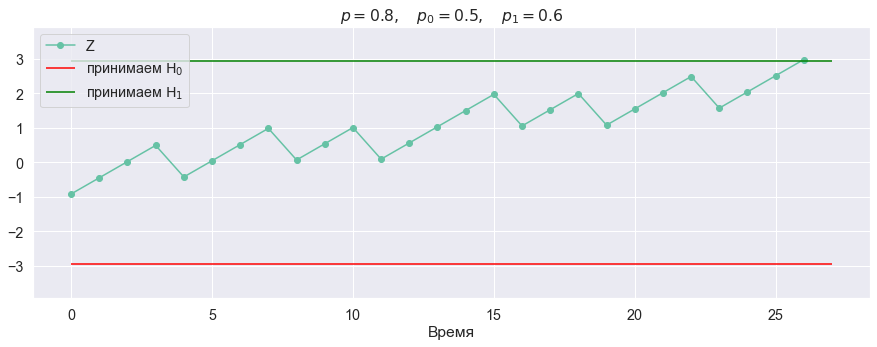

In [207]:
# вероятности ошибок
alpha = 0.05
beta = 0.05
# пороги, при которых принимаем одну из гипотез
B = (1 - beta) / alpha
A = beta / (1 - alpha)

sample = []  # тут будет выборка, пока ее нет

while len(sample) < 1e6:
    # получаем очередной элемент выборки
    sample = np.append(sample, sps.bernoulli(p=p).rvs(size=1))
    # считаем статистику
    Z = np.log(p1/p0) * sample + np.log((1 - p1) / (1 - p0)) * (1 - sample)

    clear_output(wait=True)
    plt.figure(figsize=(15, 5))
    plt.plot(Z.cumsum(), 'o-', label='Z')
    plt.hlines(np.log(A), 0, len(sample), color='red', label='принимаем $\mathsf{H}_0$')
    plt.hlines(np.log(B), 0, len(sample), color='green', label='принимаем $\mathsf{H}_1$')
    plt.title('$p = {},\ \ \ p_0 = 0.5,\ \ \ p_1 = 0.6$'.format(p))
    plt.legend()
    plt.ylim((np.log(A)-1, np.log(B)+1))
    plt.xlabel('Время')
    plt.show()
    
    if (Z.sum() <= np.log(A)) | (Z.sum() >= np.log(B)):
        break
    time.sleep(0.3)

In [208]:
print(len(sample))

27


Теперь рассчитаем примерную длину, реальную ошибку первого рода и мощность (тут мощностью будет 1 - ошибка первого рода, так как мы в любом случае получаем стат значимый результат).

In [209]:
p = 0.8  # истинное значение параметра
p0, p1 = 0.5, 0.8 # гипотезы

# вероятности ошибок
alpha = 0.05
beta = 0.05
# пороги, при которых принимаем одну из гипотез
B = (1 - beta) / alpha
A = beta / (1 - alpha)

n_iter = 200000


n_errors = 0
len_samples = []

for _ in tqdm(range(n_iter)):
    sample = []  # тут будет выборка, пока ее нет
    while len(sample) < 1e6:
        # получаем очередной элемент выборки
        sample = np.append(sample, sps.bernoulli(p=p).rvs(size=1))
        # считаем статистику
        Z = np.log(p1/p0) * sample + np.log((1 - p1) / (1 - p0)) * (1 - sample)

        if (Z.sum() <= np.log(A)) | (Z.sum() >= np.log(B)):
            len_samples.append(len(sample))
            if Z.sum() <= np.log(A):
                n_errors += 1
            break


  0%|          | 0/200000 [00:00<?, ?it/s]

In [210]:
n_errors / n_iter, np.mean(len_samples)

(0.035175, 15.765235)

**Вывод:** первый метод сошелся в среднем где-то при $n = 28.$ Теоретические рассчеты во втором пункте показали, что минимальное среднее количество наблюдений, требуемое для последовательного анализа, составляет 13-14 наблюдений. Семплирование в 3 пункте показало, что действительно, требуется примерно столько наблюдений, сколько мы предполагали во 2 пункте (если точнее, то ожадаемо получилось немного больше, где-то 15-16 наблюдений). Можем сделать вывод, что последовательный анализ эффективнее при поступлении выборки онлайн и может потребовать меньше наблюдений, что логично.

---

### Задача 2 (8 баллов)

Вам выдаются 3 файла со статистикой посещаемости страниц Физтех.Статистики, разделенные на страницы на сайте и на вики-страницах.
Каждый файл соответствует одному месяцу с января по апрель 2022. Данные сгруппированы по часам. Записывается только точка входа на сайт. Иначе говоря, сессия, в рамках которой пользователь посетил несколько страниц, учитывается только один раз. 

Задачи:
* найти аномалии в предоставленных временных рядах постфактум, то есть построить оффлайн-модель;
* построить онлайн-модель детектирования аномалий.

Можете ли вы проинтерпретировать найденные аномалии?

Сначала считаем данные.

In [572]:
january = pd.read_excel('miptstats-stats/январь.xlsx', skiprows=5)
january

,Период,https://wiki.yandex.ru/,https://mipt-stats.gitlab.io/
0,2022-01-01 00:00:00 - 2022-01-01 00:59:59,1.0,0.0
1,2022-01-01 01:00:00 - 2022-01-01 01:59:59,0.0,1.0
2,2022-01-01 02:00:00 - 2022-01-01 02:59:59,0.0,0.0
3,2022-01-01 03:00:00 - 2022-01-01 03:59:59,0.0,0.0
4,2022-01-01 04:00:00 - 2022-01-01 04:59:59,1.0,1.0
...,...,...,...
739,2022-01-31 19:00:00 - 2022-01-31 19:59:59,0.0,29.0
740,2022-01-31 20:00:00 - 2022-01-31 20:59:59,1.0,20.0
741,2022-01-31 21:00:00 - 2022-01-31 21:59:59,1.0,23.0
742,2022-01-31 22:00:00 - 2022-01-31 22:59:59,1.0,19.0


In [573]:
february = pd.read_excel('miptstats-stats/февраль.xlsx', skiprows=5)
march = pd.read_excel('miptstats-stats/март.xlsx', skiprows=5)
april = pd.read_excel('miptstats-stats/апрель.xlsx', skiprows=5)

In [574]:
all_months = pd.concat([january, february, march, april], ignore_index=True)
all_months

,Период,https://wiki.yandex.ru/,https://mipt-stats.gitlab.io/
0,2022-01-01 00:00:00 - 2022-01-01 00:59:59,1.0,0.0
1,2022-01-01 01:00:00 - 2022-01-01 01:59:59,0.0,1.0
2,2022-01-01 02:00:00 - 2022-01-01 02:59:59,0.0,0.0
3,2022-01-01 03:00:00 - 2022-01-01 03:59:59,0.0,0.0
4,2022-01-01 04:00:00 - 2022-01-01 04:59:59,1.0,1.0
...,...,...,...
2491,2022-04-14 19:00:00 - 2022-04-14 19:59:59,0.0,0.0
2492,2022-04-14 20:00:00 - 2022-04-14 20:59:59,0.0,0.0
2493,2022-04-14 21:00:00 - 2022-04-14 21:59:59,0.0,0.0
2494,2022-04-14 22:00:00 - 2022-04-14 22:59:59,0.0,0.0


Период довольно неудобно представлен. Чтоб с ним было удобнее работать, добавим колонки начало периода и конец периода типа `datetime`.

In [575]:
start = all_months['Период'].apply(lambda x: x[:19])
end = all_months['Период'].apply(lambda x: x[22:])
start_date = pd.to_datetime(start)
end_date = pd.to_datetime(end)
all_months['Начало периода'] = start_date
all_months['Конец периода'] = end_date
all_months

,Период,https://wiki.yandex.ru/,https://mipt-stats.gitlab.io/,Начало периода,Конец периода
0,2022-01-01 00:00:00 - 2022-01-01 00:59:59,1.0,0.0,2022-01-01 00:00:00,2022-01-01 00:59:59
1,2022-01-01 01:00:00 - 2022-01-01 01:59:59,0.0,1.0,2022-01-01 01:00:00,2022-01-01 01:59:59
2,2022-01-01 02:00:00 - 2022-01-01 02:59:59,0.0,0.0,2022-01-01 02:00:00,2022-01-01 02:59:59
3,2022-01-01 03:00:00 - 2022-01-01 03:59:59,0.0,0.0,2022-01-01 03:00:00,2022-01-01 03:59:59
4,2022-01-01 04:00:00 - 2022-01-01 04:59:59,1.0,1.0,2022-01-01 04:00:00,2022-01-01 04:59:59
...,...,...,...,...,...
2491,2022-04-14 19:00:00 - 2022-04-14 19:59:59,0.0,0.0,2022-04-14 19:00:00,2022-04-14 19:59:59
2492,2022-04-14 20:00:00 - 2022-04-14 20:59:59,0.0,0.0,2022-04-14 20:00:00,2022-04-14 20:59:59
2493,2022-04-14 21:00:00 - 2022-04-14 21:59:59,0.0,0.0,2022-04-14 21:00:00,2022-04-14 21:59:59
2494,2022-04-14 22:00:00 - 2022-04-14 22:59:59,0.0,0.0,2022-04-14 22:00:00,2022-04-14 22:59:59


Теперь посмотрим на данные.

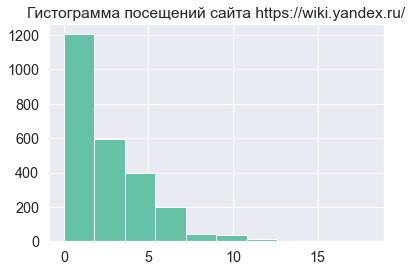

In [576]:
all_months['https://wiki.yandex.ru/'].hist()
plt.title('Гистограмма посещений сайта https://wiki.yandex.ru/')
plt.show()

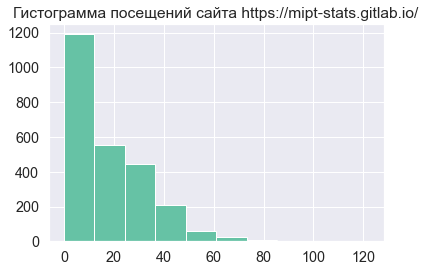

In [577]:
all_months['https://mipt-stats.gitlab.io/'].hist()
plt.title('Гистограмма посещений сайта https://mipt-stats.gitlab.io/')
plt.show()

In [578]:
all_months.describe()

,https://wiki.yandex.ru/,https://mipt-stats.gitlab.io/
count,2496.000000,2496.000000
mean,2.338542,17.853365
std,2.494477,15.455468
min,0.000000,0.000000
25%,0.000000,5.000000
50%,2.000000,14.000000
75%,4.000000,27.000000
max,18.000000,122.000000


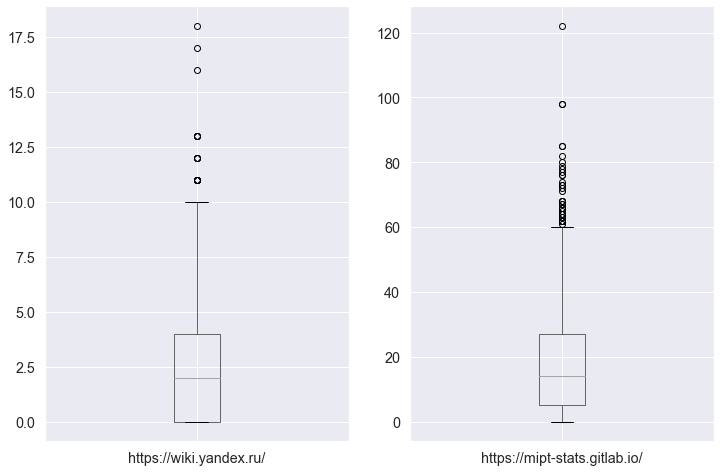

In [579]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
all_months[['https://wiki.yandex.ru/']].boxplot()
plt.subplot(1, 2, 2)
all_months[['https://mipt-stats.gitlab.io/']].boxplot()
plt.show()

In [580]:
all_months.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2496 entries, 0 to 2495
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Период                         2496 non-null   object        
 1   https://wiki.yandex.ru/        2496 non-null   float64       
 2   https://mipt-stats.gitlab.io/  2496 non-null   float64       
 3   Начало периода                 2496 non-null   datetime64[ns]
 4   Конец периода                  2496 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(2), object(1)
memory usage: 97.6+ KB


Гистограммы и боксплоты показывают, что есть выбросы, соответствующие большому количеству посещений сайта.

А сейчас попробуем посмотреть, есть ли зависимость между признаками.

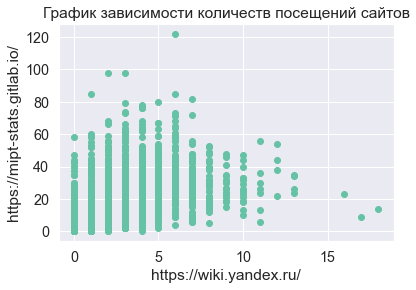

In [581]:
plt.scatter(all_months['https://wiki.yandex.ru/'], all_months['https://mipt-stats.gitlab.io/'])
plt.xlabel('https://wiki.yandex.ru/')
plt.ylabel('https://mipt-stats.gitlab.io/')
plt.title('График зависимости количеств посещений сайтов');

In [582]:
sps.spearmanr(all_months['https://wiki.yandex.ru/'], all_months['https://mipt-stats.gitlab.io/'])

SpearmanrResult(correlation=0.6711270926779634, pvalue=0.0)

График и коэффициент корреляции показывает, что есть связь между количествами посещений этих двух сайтов. Однако, возможно, это только лишь потому, что в данных, скорее всего, одинаковая сезонность: дневная или недельная. Поэтому в каждом из случаев напишем две модели: модель, которая учитывает признаки по отдельности и модель, которая учитывает признаки вместе. В качестве модели и там, и там возьмем `RobustRandomCutForest`. Также отметим, что зафиксируем, что хотим вычислить примерно 1% выбросов, и будем подбирать трешхолд аномальности, исходя из соображений, что мы хотим примерно 1% выбросов.

___

* найти аномалии в предоставленных временных рядах постфактум, то есть построить оффлайн-модель.

Сначала напишем вспомогательные функции для постройки леса, подсчета средней аномальности по лесу и отрисовки графиков.

In [584]:
def build_forest(all_months=all_months, features=['https://wiki.yandex.ru/', 'https://mipt-stats.gitlab.io/']):
    # строим лес
    forest = []
    n = len(all_months)

    num_trees = 100
    tree_size = 128
    sample_size_range = (n // tree_size, tree_size)

    while len(forest) < num_trees:
        # выбираем случайные индексы точек
        ixs = np.random.choice(n, size=sample_size_range, replace=False)
        # добавляем дерево к лесу
        trees = [rrcf.RCTree(all_months[features].iloc[ix], 
                             index_labels=ix) for ix in ixs]
        forest.extend(trees)
    
    return forest

In [585]:
def count_avg_codisp(forest):
    avg_codisp = pd.Series(0.0, index=np.arange(n))  # степень аномальности
    index = np.zeros(n)  # сколько раз точка встретилась в деревьях

    for tree in forest:
        codisp = pd.Series({leaf : tree.codisp(leaf) for leaf in tree.leaves})
        avg_codisp[codisp.index] += codisp
        np.add.at(index, codisp.index.values, 1)

    avg_codisp /= index
    return avg_codisp

In [586]:
def plot_scatters(avg_codisp, all_months=all_months, threshold=20):
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    plt.scatter(all_months['https://wiki.yandex.ru/'], all_months['https://mipt-stats.gitlab.io/'], 
                c=avg_codisp, cmap='viridis')
    plt.xlabel('https://wiki.yandex.ru/')
    plt.ylabel('https://mipt-stats.gitlab.io/')
    plt.title(label='Степень выбросов')
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.scatter(all_months['https://wiki.yandex.ru/'], all_months['https://mipt-stats.gitlab.io/'], 
                c=(avg_codisp > threshold), cmap='Set1')
    plt.xlabel('https://wiki.yandex.ru/')
    plt.ylabel('https://mipt-stats.gitlab.io/')
    plt.title(label='Выброс / не выброс')
    plt.show()

Теперь рассмотрим оффлайн-модели.

* модель, учитывающая вместе признаки

In [587]:
forest = build_forest()
avg_codisp = count_avg_codisp(forest)

In [588]:
avg_codisp.describe()

count    2496.000000
mean        4.568130
std         4.687427
min         1.160753
25%         2.589780
50%         3.402874
75%         4.728299
max        74.948571
dtype: float64

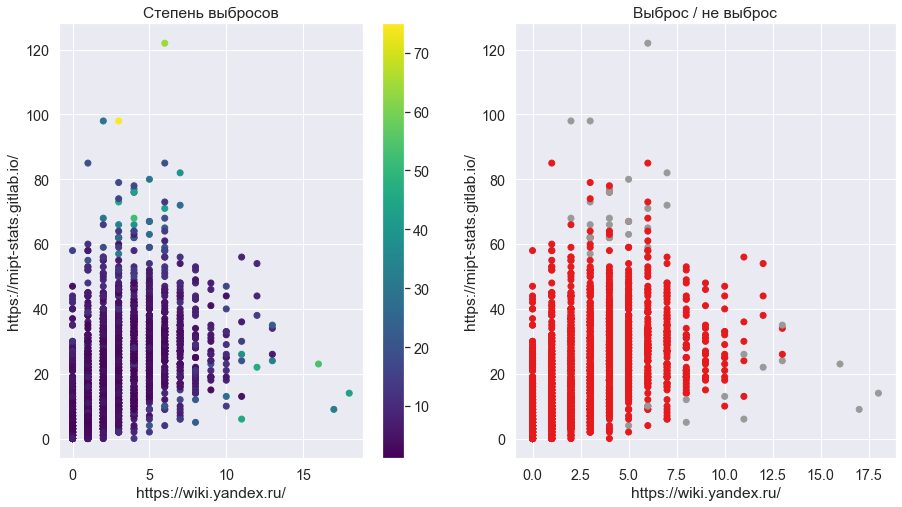

In [589]:
plot_scatters(avg_codisp)

In [590]:
threshold = 25
sum(avg_codisp > threshold) / len(avg_codisp)

0.010416666666666666

Посмотрим, относятся ли выбросы к определенной сезонности.

In [591]:
days = all_months['Начало периода'][avg_codisp > threshold].apply(lambda x: x.day_name())
days.groupby(days).count()

Начало периода
Friday       4
Monday       1
Saturday     6
Sunday       7
Tuesday      4
Wednesday    4
Name: Начало периода, dtype: int64

In [592]:
days = all_months['Начало периода'][avg_codisp > threshold].apply(lambda x: x.hour)
days.groupby(days).count()

Начало периода
10    1
13    2
15    3
16    2
17    6
18    6
19    3
21    1
22    2
Name: Начало периода, dtype: int64

Исходя из полученных графиков, можно сделать вывод, что модель выбрала в основном выделяющиеся из общей картины объекты (с большим количеством посещений сайтов). Если говорить о сезонности, то модель в основном детектирует выбросы в выходные. Возможно, это говорит не о том, что это выбросы, а о том, что в данных есть сезонность, и в эти дни пользователи просто чаще посещают рассматриваемые сайты. По дневной сезонности сложно что-то сказать, так как единственное, что можно отметить, &mdash; это что больше всего выбросов задетектированно в 5 и 6 часов, что можно считать наибольшим периодом активности пользователей.

____

* модель, учитывающая признаки по отдельности. Признак `https://wiki.yandex.ru/`

In [593]:
forest = build_forest(features=['https://wiki.yandex.ru/'])
avg_codisp = count_avg_codisp(forest)

In [594]:
avg_codisp.describe()

count    2496.000000
mean        2.817658
std         4.668052
min         0.617431
25%         1.296601
50%         1.673180
75%         2.567100
max        75.444444
dtype: float64

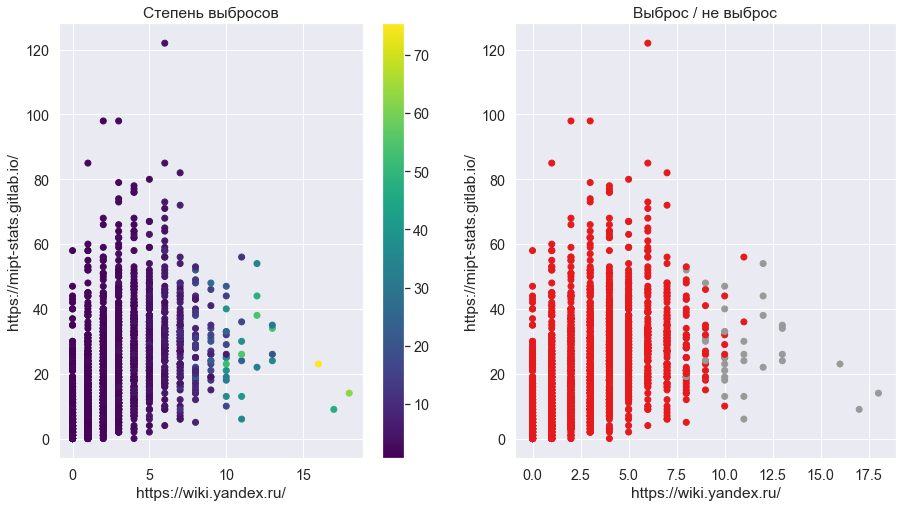

In [595]:
plot_scatters(avg_codisp, threshold=20)

In [596]:
threshold = 20
sum(avg_codisp > threshold) / len(avg_codisp)

0.013221153846153846

Посмотрим, относятся ли выбросы к определенной сезонности.

In [597]:
days = all_months['Начало периода'][avg_codisp > threshold].apply(lambda x: x.day_name())
days.groupby(days).count()

Начало периода
Friday        2
Monday        7
Saturday      4
Sunday        3
Thursday      2
Tuesday      12
Wednesday     3
Name: Начало периода, dtype: int64

In [598]:
days = all_months['Начало периода'][avg_codisp > threshold].apply(lambda x: x.hour)
days.groupby(days).count()

Начало периода
0     2
10    1
11    2
12    3
13    2
14    5
15    2
16    2
17    1
18    2
19    3
20    1
21    2
22    3
23    2
Name: Начало периода, dtype: int64

Графики показывают, что детектируются аномально большие количества посещений. Анализ сезонностей дает нам возможность сказать, что пользователи аномально часто посещают сайт `https://wiki.yandex.ru/` во вторник (если рассматривать недельную сезонность) и в 2 часа (если рассматривать дневную сезонность). Результаты легко объяснить: у нас во вторник в 4 часа дедлайн.

____

* модель, учитывающая признаки по отдельности. Признак `https://mipt-stats.gitlab.io/`

In [599]:
forest = build_forest(features=['https://mipt-stats.gitlab.io/'])
avg_codisp = count_avg_codisp(forest)

In [600]:
avg_codisp.describe()

count    2496.000000
mean        4.105740
std         4.653916
min         1.156908
25%         2.338903
50%         3.086690
75%         4.372592
max        90.703704
dtype: float64

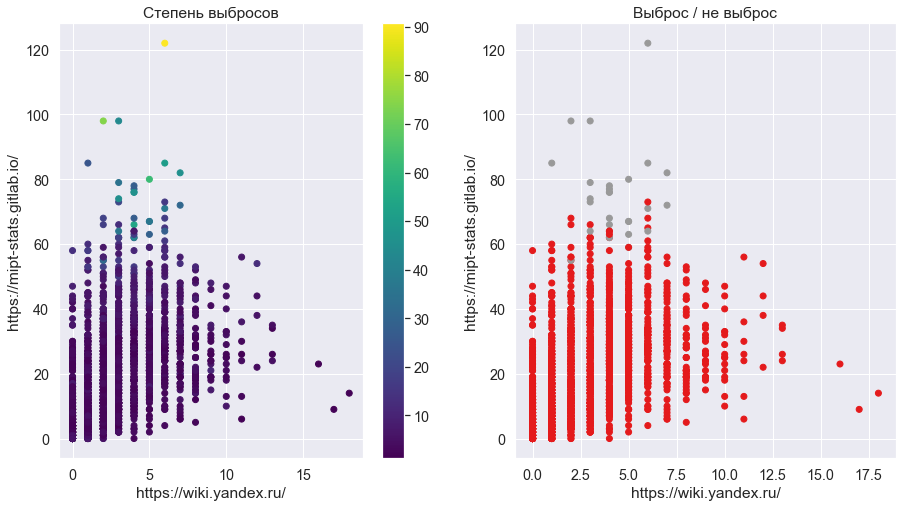

In [601]:
plot_scatters(avg_codisp, threshold=20)

In [602]:
threshold = 20
sum(avg_codisp > threshold) / len(avg_codisp)

0.011217948717948718

Посмотрим, относятся ли выбросы к определенной сезонности.

In [603]:
days = all_months['Начало периода'][avg_codisp > threshold].apply(lambda x: x.day_name())
days.groupby(days).count()

Начало периода
Friday        5
Monday        1
Saturday      7
Sunday       10
Thursday      1
Tuesday       1
Wednesday     3
Name: Начало периода, dtype: int64

In [604]:
days = all_months['Начало периода'][avg_codisp > threshold].apply(lambda x: x.hour)
days.groupby(days).count()

Начало периода
11    1
14    2
15    4
16    4
17    7
18    5
19    4
21    1
Name: Начало периода, dtype: int64

Опять же модель нашла аномально большие количества посещений рассматриваемого сайта. По сезонности можно сказать, что она очень похожа на модель, которая изучала совместно признаки. Из этого можно сделать вывод, что модель, которая изучала совместно признаки, сильнее смотрит на количества посещений сайта `https://mipt-stats.gitlab.io/`. Возможно, это происходит из-за того, что у этого признака больше масштаб, и стоило нормализовать признаки для модели, изучающей совместно признаки.

___

* построить онлайн-модель детектирования аномалий.


Посмотрим на временные ряды.

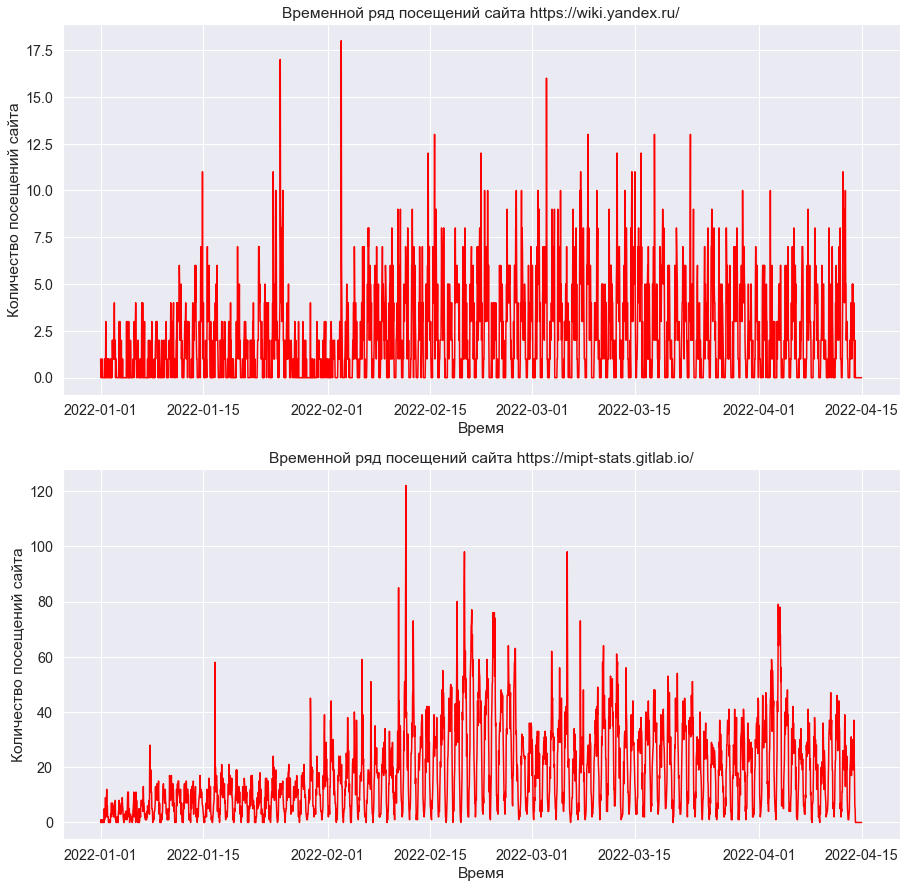

In [608]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 1, 1)
plt.plot(all_months['Начало периода'], all_months['https://wiki.yandex.ru/'], color='red')
plt.xlabel('Время')
plt.ylabel('Количество посещений сайта')
plt.title('Временной ряд посещений сайта https://wiki.yandex.ru/')
plt.subplot(2, 1, 2)
plt.plot(all_months['Начало периода'], all_months['https://mipt-stats.gitlab.io/'], color='red')
plt.xlabel('Время')
plt.ylabel('Количество посещений сайта')
plt.title('Временной ряд посещений сайта https://mipt-stats.gitlab.io/')
plt.show()

Напишем вспомогательные функции: постройки леса и подсчета аномальности, постройки графиков аномальности признаков как временных рядов и признаков в зависимости от друг друга. Выберем окно размером с день и максимальное количество точек в дереве, соответстующее 2 неделям.

In [621]:
def build_time_forest_and_count_codisp(all_months=all_months, features=['https://wiki.yandex.ru/', 
                                                                        'https://mipt-stats.gitlab.io/']):
    num_trees = 40  # количество деревьев
    shingle_size = 24  # размер окна (кол-во подряд идущих измерений)
    tree_size = 24 * 7 * 2  # максимальное количество точек в дереве

    # строим лес как список из пустых деревьев
    forest = []
    for _ in range(num_trees):
        tree = rrcf.RCTree()
        forest.append(tree)
        
        
    # Генератор для создания потока окон-точек
    points = rrcf.shingle(all_months[features].to_numpy(), 
                          size=shingle_size)

    # Словарь степени аномальности каждой точки
    avg_codisp = {}

    # Для каждого окна
    for index, point in enumerate(tqdm(points)):
        # для каждого дерева
        for tree in forest:
            # если дерево уже большое
            if len(tree.leaves) > tree_size:
                # удалим самую старую окно-точку
                tree.forget_point(index - tree_size)
            # добавим новую окно-точку
            tree.insert_point(point, index=index)
            # вычислим степень аномальности нового окна
            new_codisp = tree.codisp(index)
            # и усредним по всем деревьям
            if not index in avg_codisp:
                avg_codisp[index] = 0
            avg_codisp[index] += new_codisp / num_trees
            
    return avg_codisp

In [622]:
def build_codisp_plot(avg_codisp, ylim=(0, 140), multiplier=1, feature='https://wiki.yandex.ru/'):
    fig, ax1 = plt.subplots(figsize=(20, 10))

    # Ряд данных
    color = 'tab:red'
    ax1.set_ylabel(feature, color=color, size=14)
    ax1.plot(multiplier * all_months[feature], color=color)  # умножаем для более наглядного графика
    ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
    ax1.set_ylim(0,140)

    # Ряд степени аномальности точек
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('CoDisp', color=color, size=14)
    ax2.plot(pd.Series(avg_codisp).sort_index(), color=color)
    ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
    ax2.grid('off')
    ax2.set_ylim(0, 140);

In [623]:
def plot_time_scatters(avg_codisp, all_months=all_months, shingle_size=24, threshold=50):
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    plt.scatter(all_months['https://wiki.yandex.ru/'].iloc[:-shingle_size + 1], 
                all_months['https://mipt-stats.gitlab.io/'].iloc[:-shingle_size + 1], 
                c=pd.Series(avg_codisp).sort_index(), cmap='viridis')
    plt.xlabel('https://wiki.yandex.ru/')
    plt.ylabel('https://mipt-stats.gitlab.io/')
    plt.title(label='Степень выбросов')
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.scatter(all_months['https://wiki.yandex.ru/'].iloc[:-shingle_size + 1], 
                all_months['https://mipt-stats.gitlab.io/'].iloc[:-shingle_size + 1], 
                c=(pd.Series(avg_codisp).sort_index() > threshold), cmap='Set1')
    plt.xlabel('https://wiki.yandex.ru/')
    plt.ylabel('https://mipt-stats.gitlab.io/')
    plt.title(label='Выброс / не выброс')
    plt.show()

Теперь рассмотрим онлайн-модели.

* модель, учитывающая вместе признаки

In [624]:
avg_codisp = build_time_forest_and_count_codisp()

0it [00:00, ?it/s]

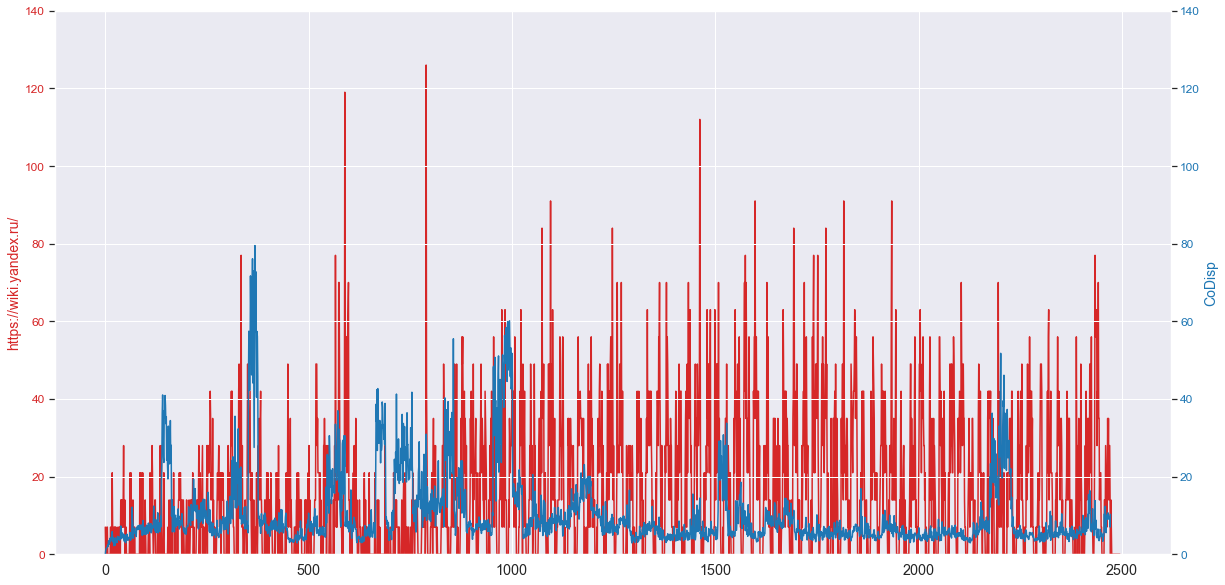

In [625]:
build_codisp_plot(avg_codisp, multiplier=7)

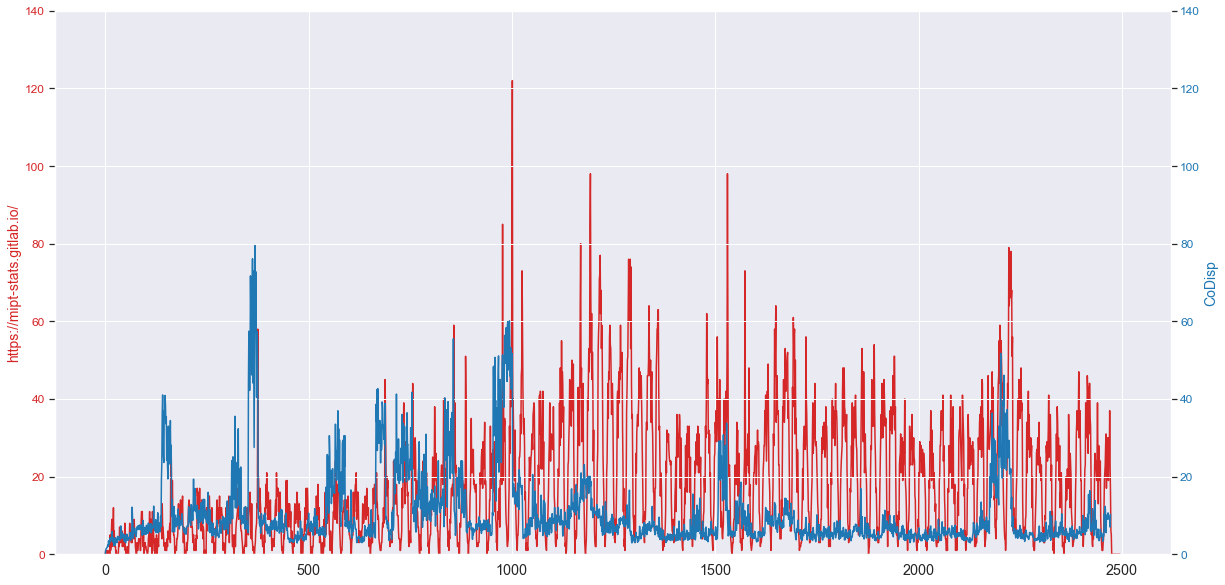

In [626]:
build_codisp_plot(avg_codisp, feature='https://mipt-stats.gitlab.io/')

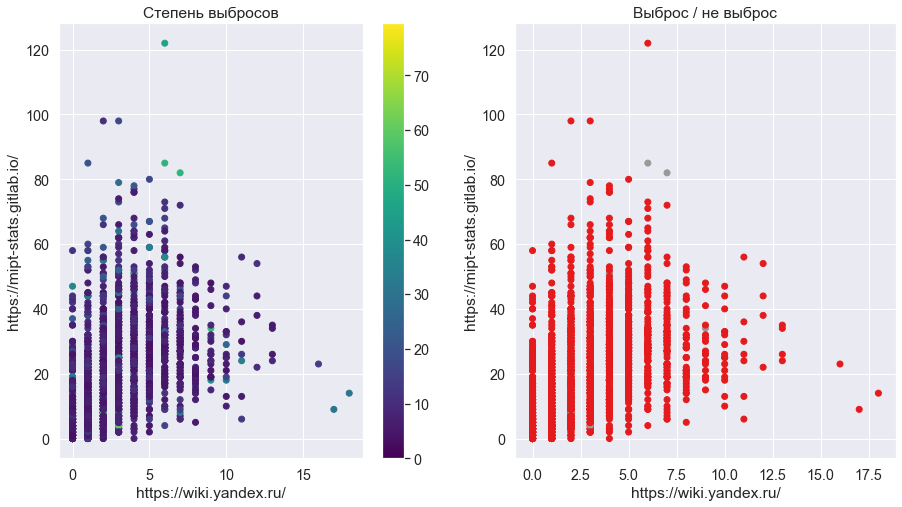

In [627]:
plot_time_scatters(avg_codisp)

In [628]:
threshold = 50
sum(pd.Series(avg_codisp).sort_index() > threshold) / len(avg_codisp)

0.01253538212697129

Посмотрим, относятся ли выбросы к определенной сезонности.

In [629]:
days = all_months['Начало периода'].iloc[:-shingle_size + 1].reset_index(drop=True)[pd.Series(avg_codisp).sort_index() > \
                                                                     threshold].apply(lambda x: x.day_name())
days.groupby(days).count()

Начало периода
Friday       10
Saturday      6
Sunday       10
Thursday      4
Wednesday     1
Name: Начало периода, dtype: int64

In [630]:
days = all_months['Начало периода'].iloc[:-shingle_size + 1].reset_index(drop=True)[pd.Series(avg_codisp).sort_index() > \
                                                                     threshold].apply(lambda x: x.hour)
days.groupby(days).count()

Начало периода
1     2
2     2
4     1
5     1
6     1
7     2
8     2
9     2
10    2
11    2
13    2
14    1
16    2
17    2
18    1
21    1
22    3
23    2
Name: Начало периода, dtype: int64

Из графика аномальности признака, как временного ряда видно, что мы начали определять как выбросы и слишком маленькое количество посещений (например, при наблюдении около 750). Также кажется, что мы детектируем выбросы с небольшим лагом (то есть, стоит рассмотреть еще элементы рядом с выбросами). По графику зависимости признаков уже не так сильно видно, что мы детектим выбросы именно как большие количества посещений. Из анализа сезонности можно сделать вывод, что дневной сезонности уже не видно (видимо, мы ее убрали окном), тогда как недельная сезонность осталась: по-прежднему больше всего выбросов в выходные и в пятницу.

___

* модель, учитывающая признаки по отдельности. Признак `https://wiki.yandex.ru/`

In [650]:
avg_codisp = build_time_forest_and_count_codisp(features=['https://wiki.yandex.ru/'])

0it [00:00, ?it/s]

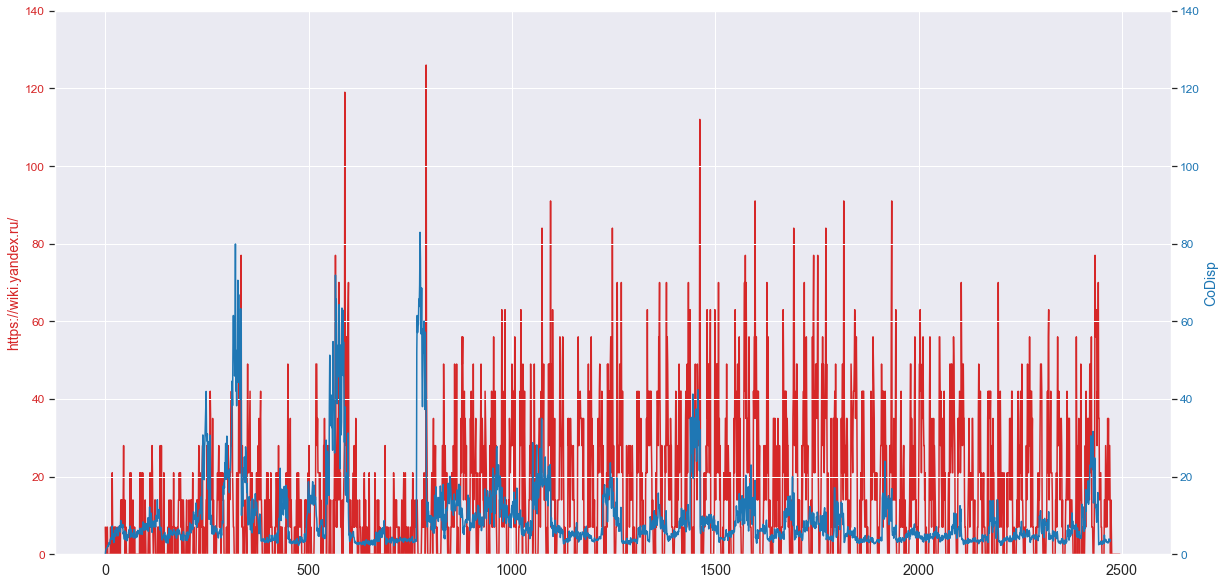

In [651]:
build_codisp_plot(avg_codisp, multiplier=7)

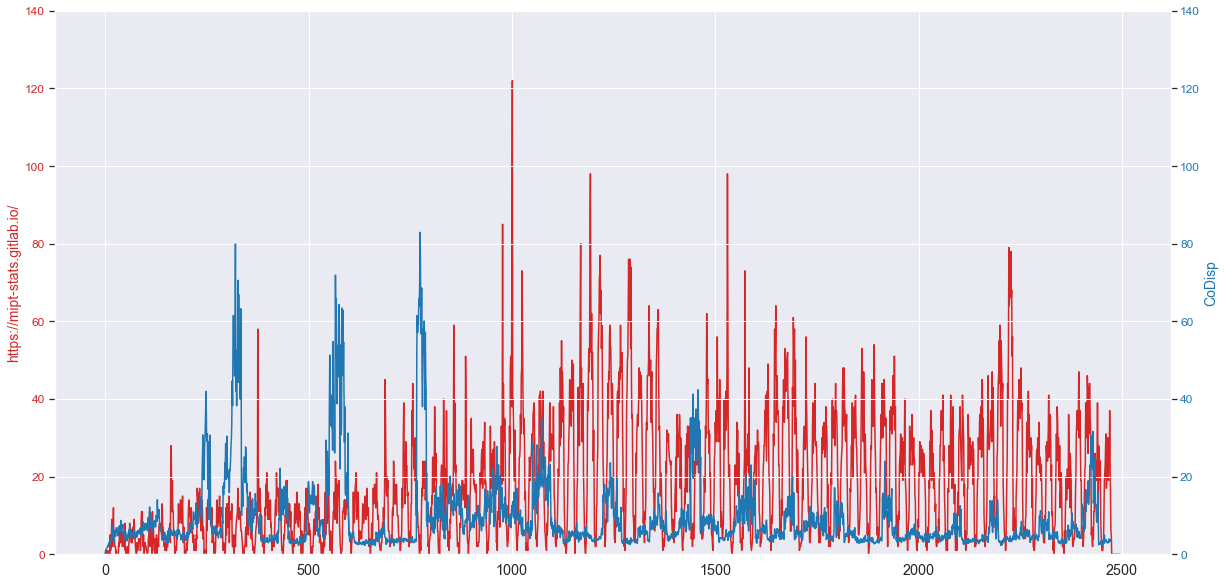

In [652]:
build_codisp_plot(avg_codisp, feature='https://mipt-stats.gitlab.io/')

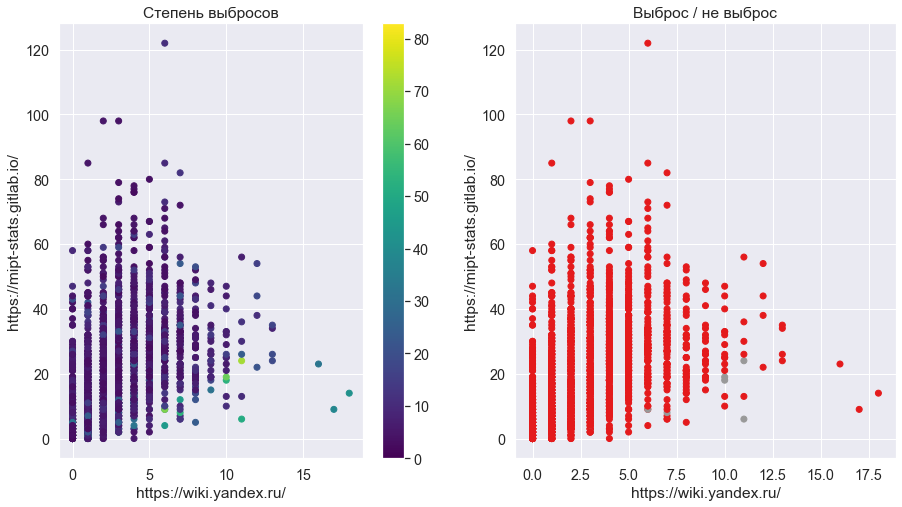

In [653]:
plot_time_scatters(avg_codisp)

In [654]:
threshold = 50
sum(pd.Series(avg_codisp).sort_index() > threshold) / len(avg_codisp)

0.01860088960776385

Посмотрим, относятся ли выбросы к определенной сезонности.

In [655]:
days = all_months['Начало периода'].iloc[:-shingle_size + 1].reset_index(drop=True)[pd.Series(avg_codisp).sort_index() > \
                                                                     threshold].apply(lambda x: x.day_name())
days.groupby(days).count()

Начало периода
Friday       12
Monday       10
Tuesday       8
Wednesday    16
Name: Начало периода, dtype: int64

In [656]:
days = all_months['Начало периода'].iloc[:-shingle_size + 1].reset_index(drop=True)[pd.Series(avg_codisp).sort_index() > \
                                                                     threshold].apply(lambda x: x.hour)
days.groupby(days).count()

Начало периода
0     3
1     1
2     3
3     3
4     2
5     2
6     2
7     2
8     4
9     1
10    2
12    1
14    3
15    2
16    3
17    2
18    1
19    2
21    2
22    3
23    2
Name: Начало периода, dtype: int64

Ожидаемо временной ряд показывает, что мы выявляем аномальности в основном только по первому признаку (так как мы обучались именно под него). Аналогично можно отметить, что теперь мы считаем за выбросы не только элементы, у которых больше всего число посещений сайта. По сезонности отметим, что дневная сезонность также исчесла, а вот недельная сезонность съехала на день, что подтверждает то, что мы определяем выбросы с лагом.

___

* модель, учитывающая признаки по отдельности. Признак `https://mipt-stats.gitlab.io/`

In [641]:
avg_codisp = build_time_forest_and_count_codisp(features=['https://mipt-stats.gitlab.io/'])

0it [00:00, ?it/s]

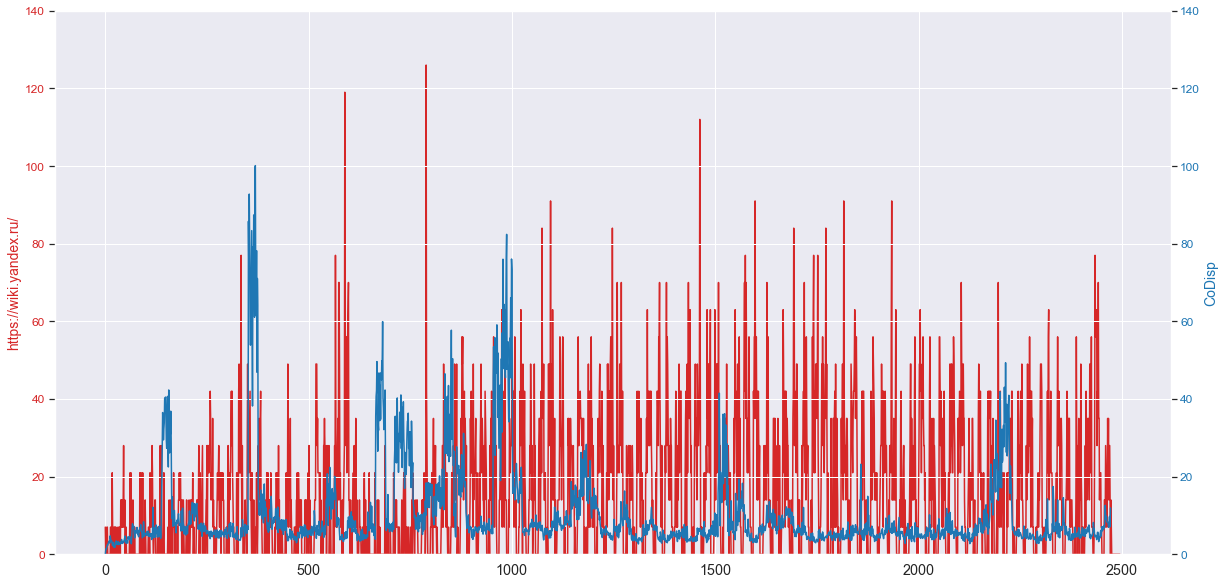

In [642]:
build_codisp_plot(avg_codisp, multiplier=7)

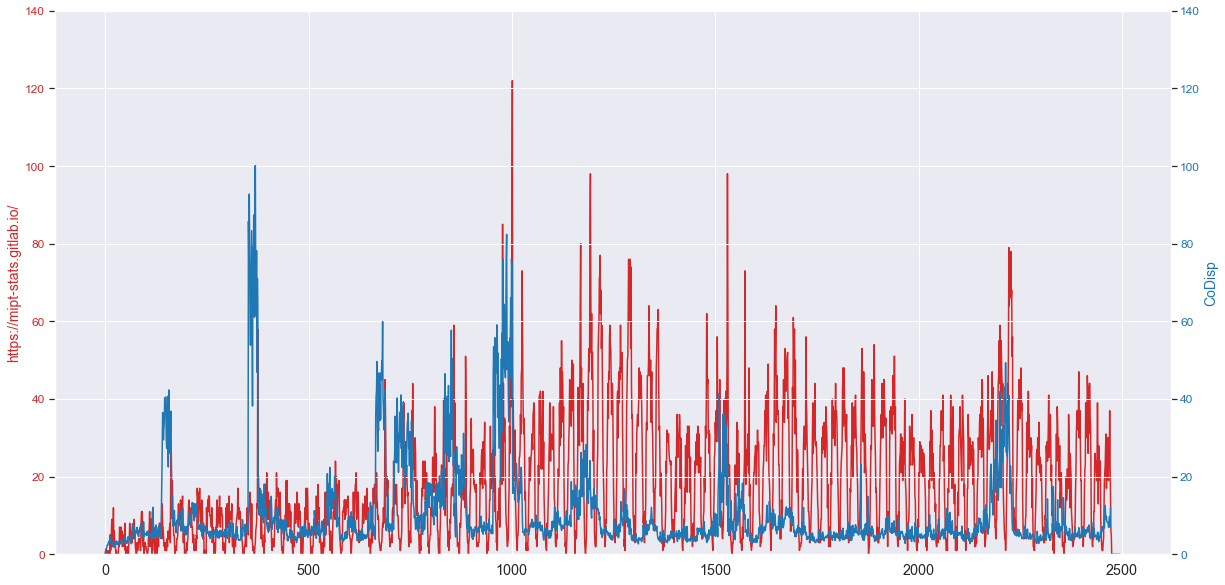

In [643]:
build_codisp_plot(avg_codisp, feature='https://mipt-stats.gitlab.io/')

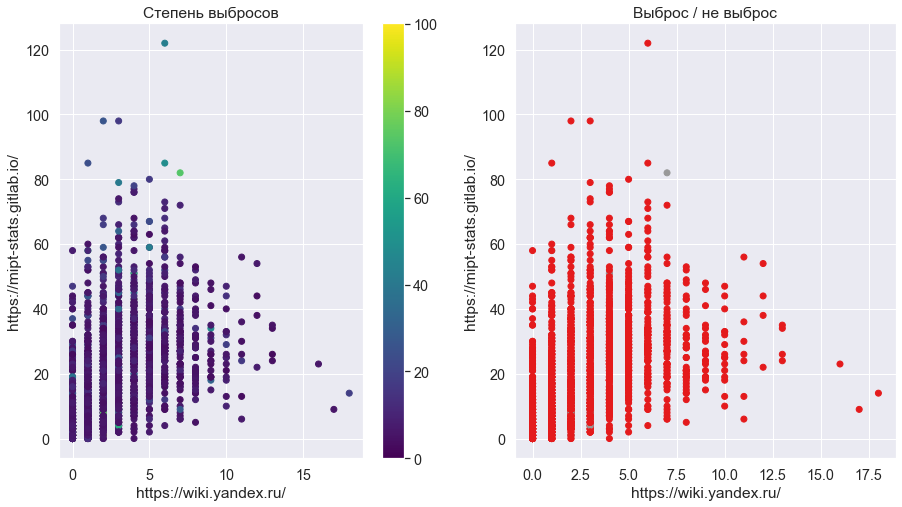

In [644]:
plot_time_scatters(avg_codisp)

In [645]:
threshold = 50
sum(pd.Series(avg_codisp).sort_index() > threshold) / len(avg_codisp)

0.01900525677315002

Посмотрим, относятся ли выбросы к определенной сезонности.

In [648]:
days = all_months['Начало периода'].iloc[:-shingle_size + 1].reset_index(drop=True)[pd.Series(avg_codisp).sort_index() > \
                                                                     threshold].apply(lambda x: x.day_name())
days.groupby(days).count()

Начало периода
Friday       10
Saturday     11
Sunday       14
Thursday     10
Wednesday     2
Name: Начало периода, dtype: int64

In [649]:
days = all_months['Начало периода'].iloc[:-shingle_size + 1].reset_index(drop=True)[pd.Series(avg_codisp).sort_index() > \
                                                                     threshold].apply(lambda x: x.hour)
days.groupby(days).count()

Начало периода
0     2
1     2
2     1
3     3
4     2
5     2
6     3
7     1
8     1
9     1
10    2
11    3
12    2
13    1
14    3
15    2
16    3
17    1
18    2
19    2
20    2
21    2
22    3
23    1
Name: Начало периода, dtype: int64

Ожидаемо временной ряд показывает, что мы выявляем аномальности в основном только по второму признаку (так как мы обучались именно под него). По графику зависимости признаков уже не так сильно видно, что мы детектим выбросы именно как большие количества посещений. По сезонности отметим, что дневная сезонность также исчесла, а вот недельная сезонность показывает, что больше всего выбросов в четверг, пятницу, субботу и воскресенье.